In [1]:
modelIn = "ClickbaitTest3"
modelOut = "ClickbaitTest4"

                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
                                              # "bert-base-cased" <---
problem_type =  "regression"                  # Possible values: "regression", "single_label_classification", "multi_label_classification"
num_labels = 1                                # 5
dataCuratedPath = "Data/Curated"              # Columns separated by ";" to avoid numeric formats nightmare:
                                              #    'postText', 'targetTitle', 'targetDescription', 'id', 'truthMean
actualOutput = 'truthMean'
computedOutput = "labelC"
inputColumn = 'postText'
removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.2                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(modelIn)
model = AutoModelForSequenceClassification.from_pretrained(
   modelIn,
   problem_type=problem_type,
   num_labels = num_labels)

In [4]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [5]:
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for param in model.bert.encoder.layer.parameters():
    param.requires_grad = False

In [6]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Hello, how are you?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Bonjour, comment ça va ?")))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour, comment ça va ?")))
print(tokenizer.decode(tokenizer.encode("Bonjour, comment ça va ?")))

{'input_ids': [101, 171, 1320, 25028, 1197, 117, 7368, 11019, 191, 1161, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['hello', ',', 'how', 'are', 'you', '?']
[101, 171, 1320, 25028, 1197, 117, 7368, 11019, 191, 1161, 136, 102]
[171, 1320, 25028, 1197, 117, 7368, 11019, 191, 1161, 136]
['[CLS]', 'b', '##on', '##jou', '##r', ',', 'comment', 'ca', 'v', '##a', '?', '[SEP]']
[CLS] bonjour, comment ca va? [SEP]


In [7]:
import datasets as ds

In [8]:
curated = ds.load_from_disk(dataCuratedPath)

In [9]:
curated.to_pandas()

,postText,targetTitle,targetDescription,truthMean,id
0,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",Law enforcement agency analysis uncovers proba...,0.066667,804113781580328960
1,The key to truly great chicken soup,A Superior Chicken Soup,For the best rendition of this American classi...,0.733333,804119512010424320
2,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,The Afghan women risking all to join the police.,0.333333,804121272967983104
3,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,"Many factors are dragging down NFL ratings, in...",0.066667,804123103995580416
4,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,"Seattle Seahawks news, rumors, scores, schedul...",0.133333,804126501117435904
...,...,...,...,...,...
21907,Man who received world's first penis transplan...,World's first penis transplant patient is set ...,"Surgeons at Stellenbosch University, who carri...",0.600000,609056814819323905
21908,"RT @NYTSports: Abby didn't start, team couldn'...","At Women’s World Cup, Tie Leaves U.S. on Solid...",With Abby Wambach not starting for the first t...,0.266667,610125815116865536
21909,Obama defends Affordable Care Act ahead of Sup...,Obama Defends Health Law Ahead of Supreme Cour...,President Obama talks at the G7 summit in Germ...,0.400000,608338587495628801
21910,New study of the Deflategate report concludes ...,Deflating ‘Deflategate’,A new study weakens the case against the Patri...,0.400000,609684420082180096


In [10]:
longueur= len(curated)
longueur

21912

In [11]:
trie=sorted(curated[actualOutput])

In [12]:
import matplotlib.pyplot as plt

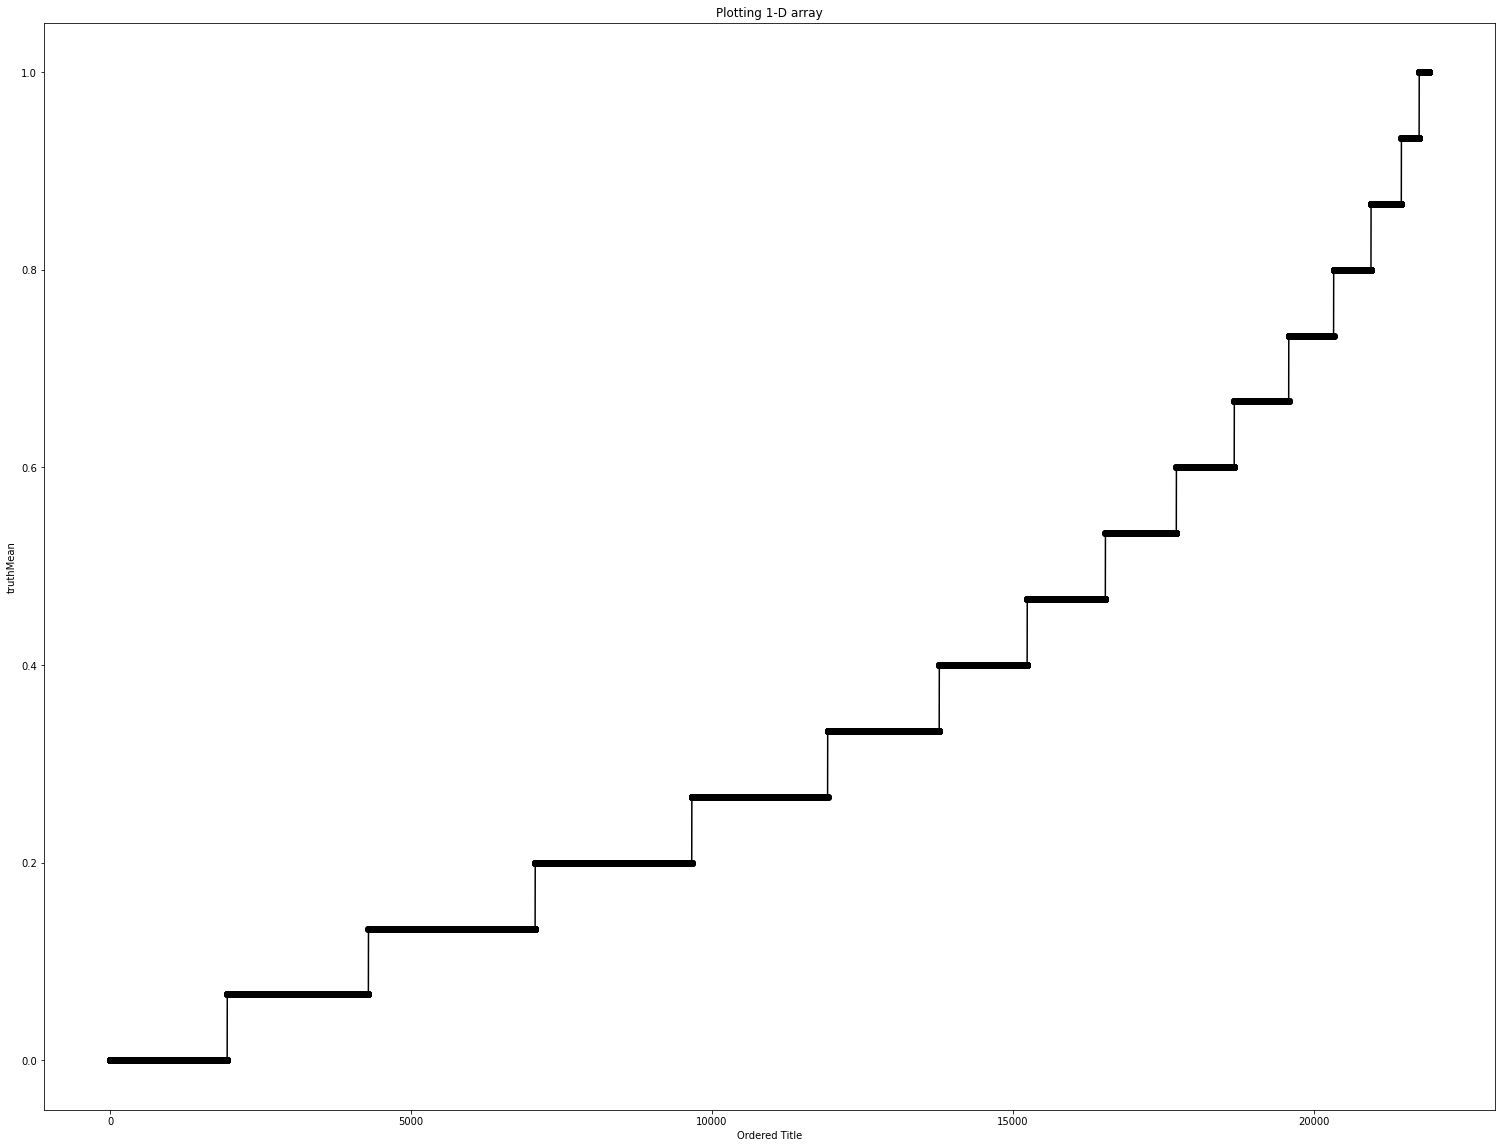

In [13]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(actualOutput)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [14]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[]

In [15]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            # str(int(sample[LCfraction]*100)), # on donne direct le résultat pour voir si accuracy == 1
            #padding=True,
            #truncation=True,
            #max_length=30
            )

    fraction = sample[actualOutput]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    
    # print( fraction, tokenized_sample["input_ids"], tokenized_sample["labels"], sample[inputColumn])
    
    return tokenized_sample

In [16]:
tokenized_curated = curated.map(tokenize) #, batched=True)

  0%|          | 0/21912 [00:00<?, ?ex/s]

In [17]:
tokenized_curated

Dataset({
    features: ['postText', 'targetTitle', 'targetDescription', 'truthMean', 'id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 21912
})

In [18]:
tokenized_curated.to_pandas().describe()

,truthMean,labels
count,21912.000000,21912.000000
mean,0.327942,0.327942
std,0.250260,0.250260
min,0.000000,0.000000
25%,0.133333,0.133333
50%,0.266667,0.266667
75%,0.466667,0.466667
max,1.000000,1.000000


In [19]:
print(tokenized_curated[0:3])

{'postText': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'The key to truly great chicken soup', 'Afghan policewomen face down their fears to serve'], 'targetTitle': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'A Superior Chicken Soup ', '100 Women 2016: On the frontline with the women policing the peace in Afghanistan'], 'targetDescription': ['Law enforcement agency analysis uncovers probable matches connected to terrorism, money laundering and organised crime', 'For the best rendition of this American classic, start with a whole bird.', 'The Afghan women risking all to join the police.'], 'truthMean': [0.06666666666, 0.73333333332, 0.33333333330000003], 'id': ['804113781580328960', '804119512010424320', '804121272967983104'], 'input_ids': [[101, 13316, 7363, 4580, 131, 27772, 23043, 6743, 124, 117, 2260, 2666, 1106, 6321, 13037, 102], [101, 1103, 2501, 1106, 5098, 1632, 9323, 13128, 102], [101, 170, 2087, 23136, 2021, 12821, 2354, 1339, 

In [20]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [21]:
tokenized_curated2['train'].to_pandas()

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels
0,Here's how most people have anal sex,Here's How Most People Have Anal Sex,,0.933333,855573366908088320,"[101, 1303, 112, 188, 1293, 1211, 1234, 1138, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.933333
1,NT family vows to rebuild tattoo parlour gutte...,NT family vows to rebuild tattoo parlour gutte...,Police believe that a device similar to a Molo...,0.133333,815035667579142144,"[101, 183, 1204, 1266, 18095, 1106, 15596, 132...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
2,Greek debt-relief measures unblocked by eurozone,Greek Debt-Relief Measures Unblocked by Eurozone,Greece’s eurozone creditors agreed to unblock ...,0.266667,812982743038652416,"[101, 176, 8871, 1377, 6695, 118, 3893, 5252, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.266667
3,American Pharoah lands on the Sports Illustrat...,American Pharoah Lands on Sports Illustrated C...,American Pharoah made history Saturday when ...,0.800000,608327168507179008,"[101, 1821, 26237, 1389, 185, 7111, 12985, 132...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.800000
4,Argentina tried a Trump-like tariff -- and it ...,Argentina tried a Trump-like tariff -- and it ...,Argentina is getting rid of a 35% tariff -- th...,0.600000,810967962693890048,"[101, 170, 14527, 2983, 1793, 170, 189, 27321,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000
...,...,...,...,...,...,...,...,...,...
17524,"Melissa McCarthy is Easter Spicey, the apologi...","Melissa McCarthy Is Easter Spicey, The Apologi...","""SNL"" brought back the faux press secretary an...",0.200000,853501279875858433,"[101, 1143, 6137, 3202, 182, 19495, 11687, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000
17525,Cops have arrested a man in Nashville for putt...,Cops: Nashville man put mom's dog in trash com...,The Shih Tzu died four days later,0.200000,839675864891682817,"[101, 11396, 1138, 3950, 170, 1299, 1107, 9468...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000
17526,Buzz Aldrin evacuated from South Pole,Buzz Aldrin Arrives in New Zealand After Being...,"From Yahoo: Buzz Aldrin, the second man on the...",0.133333,804540397871632384,"[101, 19859, 2393, 23632, 1394, 13776, 1121, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.133333
17527,Iran's supreme court has ruled that a woman mu...,Iran to blind acid-attack woman in Sharia retr...,Iran's supreme court has ruled that a woman mu...,0.000000,827449048831365122,"[101, 178, 4047, 112, 188, 14777, 2175, 1144, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000


In [22]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [23]:
tokenized_curated4 = tokenized_curated3

In [24]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17529
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4383
    })
})

In [25]:
print(tokenized_curated4["train"][0:20])

{'input_ids': [[101, 1303, 112, 188, 1293, 1211, 1234, 1138, 24443, 2673, 102], [101, 183, 1204, 1266, 18095, 1106, 15596, 13271, 14247, 25090, 9691, 1906, 1118, 1783, 2021, 1474, 1110, 10108, 102], [101, 176, 8871, 1377, 6695, 118, 3893, 5252, 8362, 27467, 1174, 1118, 27772, 19315, 102], [101, 1821, 26237, 1389, 185, 7111, 12985, 1324, 4508, 1113, 1103, 2865, 8292, 2267, 1105, 1122, 787, 188, 1141, 1111, 1103, 6776, 102], [101, 170, 14527, 2983, 1793, 170, 189, 27321, 118, 1176, 27629, 17387, 118, 118, 1105, 1122, 1355, 16358, 14791, 4999, 2488, 102], [101, 6001, 1111, 170, 23639, 12574, 1144, 1309, 1151, 5747, 119, 1303, 112, 188, 170, 6388, 1106, 1494, 131, 102], [101, 2824, 2490, 2222, 1106, 2774, 137, 179, 10559, 3633, 1605, 1107, 1117, 2280, 19863, 12805, 7222, 1113, 108, 188, 1179, 1233, 119, 102], [101, 1121, 21359, 20192, 1116, 13395, 1106, 1103, 21359, 20192, 2316, 136, 26227, 8053, 12477, 25453, 1279, 2947, 1107, 1668, 122, 1107, 1412, 6270, 14660, 5039, 102], [101, 1888, 13

In [26]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelOut,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  # save_steps = 50,
                                  # save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  optim= 'adamw_torch',
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  learning_rate=learning_rate,
                                  weight_decay=weight_decay,
                                  #push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

In [28]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [29]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [30]:
# faire la boucle avec le trainer pytorch
# %pdb
if (modelIn != modelOut):
    trainer.train()

***** Running training *****
  Num examples = 17529
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4384


Step,Training Loss,Validation Loss,Mse
50,No log,0.031384,0.031384
100,No log,0.025176,0.025176
150,No log,0.026712,0.026712
200,No log,0.026789,0.026789
250,No log,0.025446,0.025446
300,No log,0.024967,0.024967
350,No log,0.025037,0.025037
400,No log,0.025867,0.025867
450,No log,0.024951,0.024951
500,0.029200,0.024548,0.024548


***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
Saving model checkpoint to ClickbaitTest4/checkpoint-500
Configuration saved in ClickbaitTest4/checkpoint-500/config.json
Model weights saved in ClickbaitTest4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ClickbaitTest4/checkpoint-500/tokenizer_config.json
Special tokens

In [31]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16


{'eval_loss': 0.02454771101474762,
 'eval_mse': 0.024547711458327903,
 'eval_runtime': 8.736,
 'eval_samples_per_second': 501.717,
 'eval_steps_per_second': 31.364,
 'epoch': 0.91}

In [32]:
# Sauver le modèle sur le disque
if (modelIn != modelOut):
    model.save_pretrained(modelOut)

Configuration saved in ClickbaitTest4/config.json
Model weights saved in ClickbaitTest4/pytorch_model.bin


In [33]:
if (modelIn != modelOut):
    tokenizer.save_vocabulary(modelOut)

In [50]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "train" #  "train" # "test"

In [51]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated2[overfitting])

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, postText, targetTitle, targetDescription, truthMean. If id, postText, targetTitle, targetDescription, truthMean are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 17529
  Batch size = 16


In [52]:
predictions.predictions

array([[0.8570891 ],
       [0.1692082 ],
       [0.18509053],
       ...,
       [0.17204948],
       [0.13791433],
       [0.24280484]], dtype=float32)

In [53]:
predictions.metrics

{'test_loss': 0.024875028058886528,
 'test_mse': 0.0248750284657241,
 'test_runtime': 37.1069,
 'test_samples_per_second': 472.393,
 'test_steps_per_second': 29.536}

In [54]:
tct = tokenized_curated2[overfitting].to_pandas()

In [55]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels
0,Here's how most people have anal sex,Here's How Most People Have Anal Sex,,0.933333,855573366908088320,"[101, 1303, 112, 188, 1293, 1211, 1234, 1138, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.933333
1,NT family vows to rebuild tattoo parlour gutte...,NT family vows to rebuild tattoo parlour gutte...,Police believe that a device similar to a Molo...,0.133333,815035667579142144,"[101, 183, 1204, 1266, 18095, 1106, 15596, 132...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
2,Greek debt-relief measures unblocked by eurozone,Greek Debt-Relief Measures Unblocked by Eurozone,Greece’s eurozone creditors agreed to unblock ...,0.266667,812982743038652416,"[101, 176, 8871, 1377, 6695, 118, 3893, 5252, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.266667
3,American Pharoah lands on the Sports Illustrat...,American Pharoah Lands on Sports Illustrated C...,American Pharoah made history Saturday when ...,0.800000,608327168507179008,"[101, 1821, 26237, 1389, 185, 7111, 12985, 132...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.800000
4,Argentina tried a Trump-like tariff -- and it ...,Argentina tried a Trump-like tariff -- and it ...,Argentina is getting rid of a 35% tariff -- th...,0.600000,810967962693890048,"[101, 170, 14527, 2983, 1793, 170, 189, 27321,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000
...,...,...,...,...,...,...,...,...,...
17524,"Melissa McCarthy is Easter Spicey, the apologi...","Melissa McCarthy Is Easter Spicey, The Apologi...","""SNL"" brought back the faux press secretary an...",0.200000,853501279875858433,"[101, 1143, 6137, 3202, 182, 19495, 11687, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000
17525,Cops have arrested a man in Nashville for putt...,Cops: Nashville man put mom's dog in trash com...,The Shih Tzu died four days later,0.200000,839675864891682817,"[101, 11396, 1138, 3950, 170, 1299, 1107, 9468...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000
17526,Buzz Aldrin evacuated from South Pole,Buzz Aldrin Arrives in New Zealand After Being...,"From Yahoo: Buzz Aldrin, the second man on the...",0.133333,804540397871632384,"[101, 19859, 2393, 23632, 1394, 13776, 1121, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.133333
17527,Iran's supreme court has ruled that a woman mu...,Iran to blind acid-attack woman in Sharia retr...,Iran's supreme court has ruled that a woman mu...,0.000000,827449048831365122,"[101, 178, 4047, 112, 188, 14777, 2175, 1144, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000


In [56]:
if num_labels == 1:
    tct[computedOutput] = predictions.predictions
else:
    tct[computedOutput] = np.argmax(predictions.predictions, axis=1)   

In [57]:
tct1 = tct.sort_values(actualOutput)
tct2 = tct.sort_values(computedOutput)

In [58]:
palette = ["r", "g", "b", "c", "m"]

In [59]:
if num_labels == 1:
    color1 = [val for val in tct1[computedOutput]]
    color2 = [val for val in tct1[actualOutput]]
else:
    color1 = [palette[val] for val in tct1[computedOutput]]
    color2 = [palette[val] for val in tct1[actualOutput]]

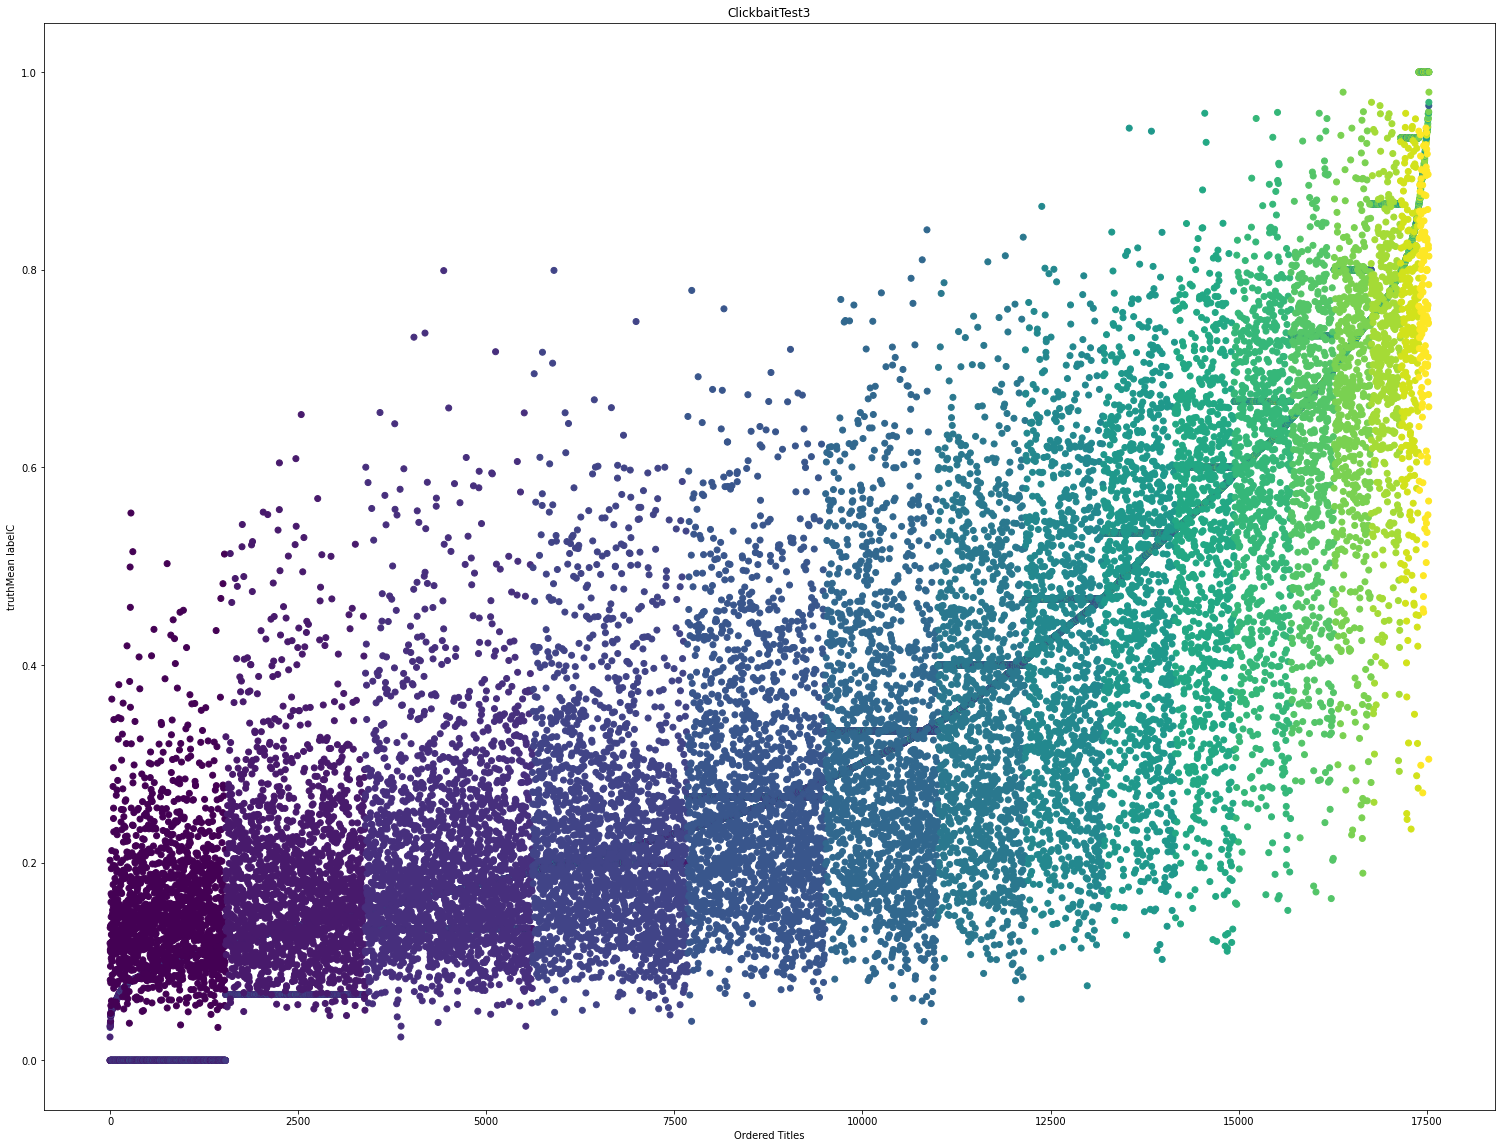

In [60]:
plt.figure(figsize=(26, 20))
plt.title(modelIn)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = np.array(range(0, tct1.shape[0]))
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = "o", label = "Array elements")


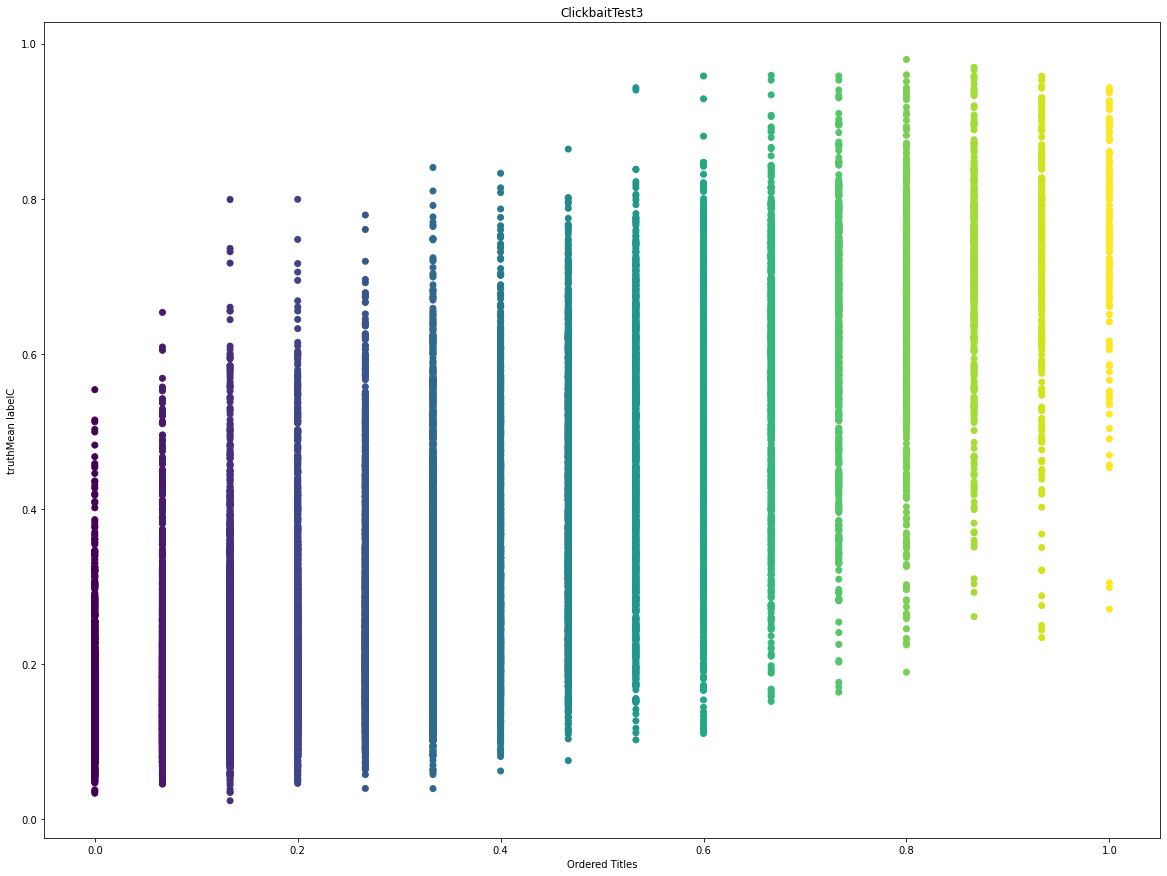

In [61]:
plt.figure(figsize=(20, 15))
plt.title(modelIn)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
# plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
# plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = tct1[actualOutput]
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = "o", label = "Array elements")

In [62]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels,labelC
0,Here's how most people have anal sex,Here's How Most People Have Anal Sex,,0.933333,855573366908088320,"[101, 1303, 112, 188, 1293, 1211, 1234, 1138, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.933333,0.857089
1,NT family vows to rebuild tattoo parlour gutte...,NT family vows to rebuild tattoo parlour gutte...,Police believe that a device similar to a Molo...,0.133333,815035667579142144,"[101, 183, 1204, 1266, 18095, 1106, 15596, 132...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.169208
2,Greek debt-relief measures unblocked by eurozone,Greek Debt-Relief Measures Unblocked by Eurozone,Greece’s eurozone creditors agreed to unblock ...,0.266667,812982743038652416,"[101, 176, 8871, 1377, 6695, 118, 3893, 5252, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.266667,0.185091
3,American Pharoah lands on the Sports Illustrat...,American Pharoah Lands on Sports Illustrated C...,American Pharoah made history Saturday when ...,0.800000,608327168507179008,"[101, 1821, 26237, 1389, 185, 7111, 12985, 132...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.800000,0.258440
4,Argentina tried a Trump-like tariff -- and it ...,Argentina tried a Trump-like tariff -- and it ...,Argentina is getting rid of a 35% tariff -- th...,0.600000,810967962693890048,"[101, 170, 14527, 2983, 1793, 170, 189, 27321,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.606858
...,...,...,...,...,...,...,...,...,...,...
17524,"Melissa McCarthy is Easter Spicey, the apologi...","Melissa McCarthy Is Easter Spicey, The Apologi...","""SNL"" brought back the faux press secretary an...",0.200000,853501279875858433,"[101, 1143, 6137, 3202, 182, 19495, 11687, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.217556
17525,Cops have arrested a man in Nashville for putt...,Cops: Nashville man put mom's dog in trash com...,The Shih Tzu died four days later,0.200000,839675864891682817,"[101, 11396, 1138, 3950, 170, 1299, 1107, 9468...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.177794
17526,Buzz Aldrin evacuated from South Pole,Buzz Aldrin Arrives in New Zealand After Being...,"From Yahoo: Buzz Aldrin, the second man on the...",0.133333,804540397871632384,"[101, 19859, 2393, 23632, 1394, 13776, 1121, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.133333,0.172049
17527,Iran's supreme court has ruled that a woman mu...,Iran to blind acid-attack woman in Sharia retr...,Iran's supreme court has ruled that a woman mu...,0.000000,827449048831365122,"[101, 178, 4047, 112, 188, 14777, 2175, 1144, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000,0.137914


In [63]:
tct[[computedOutput, actualOutput]].describe()

,labelC,truthMean
count,17529.000000,17529.000000
mean,0.330264,0.328960
std,0.204062,0.249981
min,0.023664,0.000000
25%,0.168457,0.133333
50%,0.260551,0.266667
75%,0.464924,0.466667
max,0.979630,1.000000


In [64]:
tct.corr()

,truthMean,labels,labelC
truthMean,1.000000,1.000000,0.776853
labels,1.000000,1.000000,0.776853
labelC,0.776853,0.776853,1.000000


In [49]:
from transformers import pipeline

In [51]:
model.to(torch.device("cpu"))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [52]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [53]:
classifier

In [54]:
classifier("Nous sommes très heureux de vous présenter la bibliothèque 🤗 Transformers.")

[{'label': 'LABEL_0', 'score': 0.5740309953689575}]

In [55]:
classifier(["The key to truly great chicken soup", "La clef d'une bonne soupe au poulet"])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'LABEL_0', 'score': 0.6501203179359436},
 {'label': 'LABEL_0', 'score': 0.6026092171669006}]

In [56]:
classifier("Traité de mathématiques amusantes.")

[{'label': 'LABEL_0', 'score': 0.63006192445755}]

In [57]:
tct.loc[tct.labelC != tct.labels]

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels,labelC
0,Hospitals overcharging for #stents will be pen...,Govt Begins Crackdown On Hospital Overcharging...,"Govt Cracks Whip, Asks Hospitals To Stock Sten...",0.000000,832854687141490689,"[101, 8894, 1166, 7147, 10805, 1158, 1111, 108...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000,0.148465
1,"Kiesza discusses ""immense tragedy"" preceding s...",Kiesza Discusses 'Immense Tragedy' Preceding S...,âHideawayâ star Kiesza discusses âDearly...,0.200000,824346385575268368,"[101, 180, 1905, 3293, 16900, 107, 14934, 1234...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.138477
2,"Inside Lapland's palatial Icehotel, with its -...",What it's like to sleep in a (luxury) freezer:...,MailOnline's Annabel Fenwick Elliott spent a n...,0.133333,835902333334732800,"[101, 1656, 4443, 1931, 112, 188, 185, 5971, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.265146
3,Van crashes into plane at Dallas airport via @...,Van Crashes Into Plane at Dallas Airport,A catering van crashed into the rear of a jetl...,0.000000,609601544137375744,"[101, 3498, 21110, 1154, 4261, 1120, 5358, 239...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000,0.185028
4,Why sex harassment scandals like Uber's are bo...,Why sexual harassment scandals like Uber's are...,Letting other big-name companies shoulder the ...,0.466667,834211808743419904,"[101, 1725, 2673, 17514, 10083, 1116, 1176, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.466667,0.574904
...,...,...,...,...,...,...,...,...,...,...
4378,Soulja Boy calls out Kanye West's fashion infl...,Soulja Boy Calls Out Kanye West's Fashion Infl...,"Soulja Boy keeps on talking, this time calling...",0.133333,821820709567680513,"[101, 3960, 3174, 2298, 3675, 1149, 24181, 338...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.186222
4379,Elon Musk reveals his plans for ending traffic...,Land And Air Travel Aren't Enough For Elon Mus...,The restless Tesla/SpaceX CEO is bringing his ...,0.133333,858123680454512640,"[101, 8468, 1320, 182, 24493, 7189, 1117, 2714...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.205253
4380,Britain's eccentric lay-by businesses,On the roads discovering Britain's eccentric l...,"Lay-by businesses, selling everything from bur...",0.733333,609535452782198785,"[101, 9304, 5168, 1394, 112, 188, 20276, 3191,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.733333,0.536122
4381,This man wore a suit to meet his new nephew be...,This man wore a suit to meet his new nephew be...,Iris Kessler tweeted this (amazing) picture of...,0.600000,816983857350275072,"[101, 1142, 1299, 4307, 170, 4228, 1106, 2283,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.572962


In [58]:
classifier("99% des gens n'arrivent pas à voir le chien sur cette image", return_all_scores=True)

[[{'label': 'LABEL_0', 'score': 0.5732000470161438}]]